### Dependencies

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


### Data Exploration and Pre-processing

In [4]:
ds_train, ds_info_train = tfds.load('mnist', split = 'train', with_info = True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


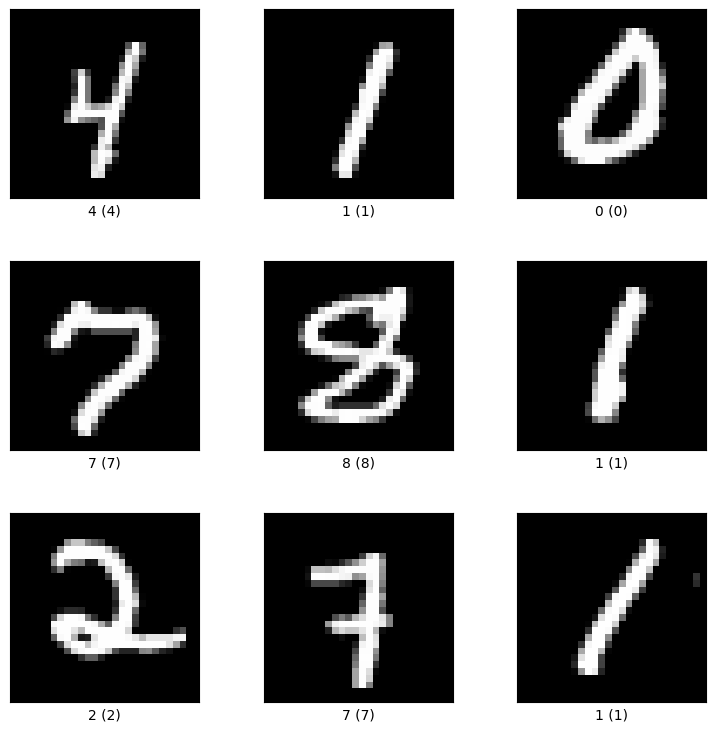

In [5]:
fig = tfds.show_examples(ds_train, ds_info_train)

In [6]:
len(ds_train)

60000

In [9]:
def preprocess_data(sample):
    image = tf.image.resize(sample['image'], (28, 28))  # resize to 64x64
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(sample['label'], ds_info_train.features['label'].num_classes)
    return image, label

In [10]:
# Preprocess the training data
ds_train = ds_train.map(preprocess_data)
ds_train = ds_train.shuffle(1000).batch(64)  # Shuffle and batch the data

### Building and testing the networks

In [19]:
#discriminator model
discriminator_model = tf.keras.Sequential(name="discriminator_model")

discriminator_model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator_model.add(tf.keras.layers.Dropout(0.25))

discriminator_model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
discriminator_model.add(tf.keras.layers.BatchNormalization())
discriminator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
discriminator_model.add(tf.keras.layers.Dropout(0.25))

discriminator_model.add(tf.keras.layers.Flatten())
discriminator_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

discriminator_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                            loss='binary_crossentropy', metrics=['accuracy'])

discriminator_model.summary()

Model: "discriminator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                               

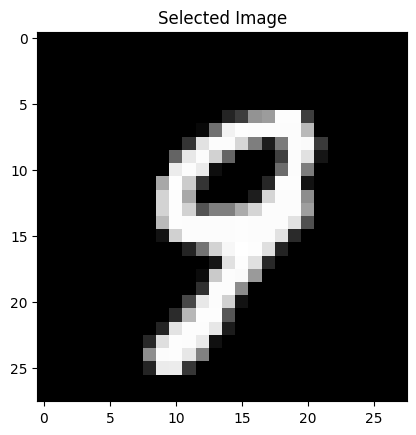

1/1 [==============================] - 0s 22ms/step
Discriminator Output: [[0.5014479]]


In [21]:
for real_images, _ in ds_train.take(1):
    test_image = real_images[0:1]

    plt.imshow(test_image.numpy().reshape(28, 28, 1), cmap = 'gray')
    plt.title("Selected Image")
    plt.show()

    prediction = discriminator_model.predict(test_image)

    print("Discriminator Output:", prediction)

In [31]:
#generator model

noise_dim = (100,)
generator_model = tf.keras.Sequential(name="generator_model")

generator_model.add(tf.keras.layers.Dense(7 * 7 * 128, input_shape=noise_dim))
generator_model.add(tf.keras.layers.Reshape((7, 7, 128)))

generator_model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'))
generator_model.add(tf.keras.layers.BatchNormalization())
generator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))

generator_model.add(tf.keras.layers.Conv2DTranspose(1, (4, 4), strides=(2, 2), activation='sigmoid', padding='same'))  # Output layer with 1 channel for MNIST grayscale

generator_model.summary()

Model: "generator_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6272)              633472    
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_29 (Conv2  (None, 14, 14, 64)        131136    
 DTranspose)                                                     
                                                                 
 batch_normalization_22 (Ba  (None, 14, 14, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_30 (Conv2  (None, 28, 28, 1)     

1/1 [==============================] - 0s 48ms/step
(28, 28, 1)


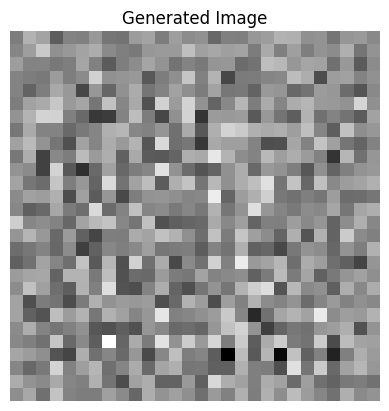

In [33]:
# Generate random noise as input for the generator
noise = tf.random.normal(shape=(1, 100))

generated_image = generator_model.predict(noise)
print(generated_image.shape[1:])
generated_image_rescaled = 0.5 * generated_image + 0.5

plt.imshow(generated_image_rescaled[0, :, :, :], cmap = 'gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()

### Combining the networks for the GAN

Epoch 0
 disc loss: 0.17660638689994812, disc acc: 0.5
 gen loss: 0.8129542469978333


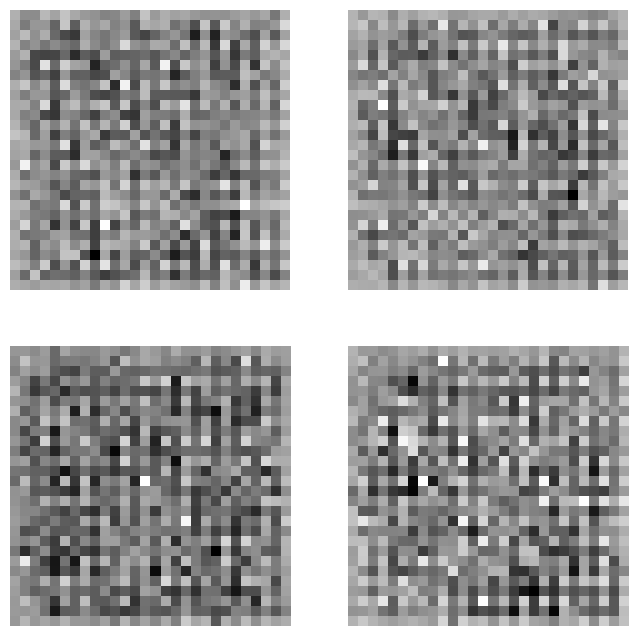

Epoch 500
 disc loss: 0.368584543466568, disc acc: 0.484375
 gen loss: 0.0179190281778574


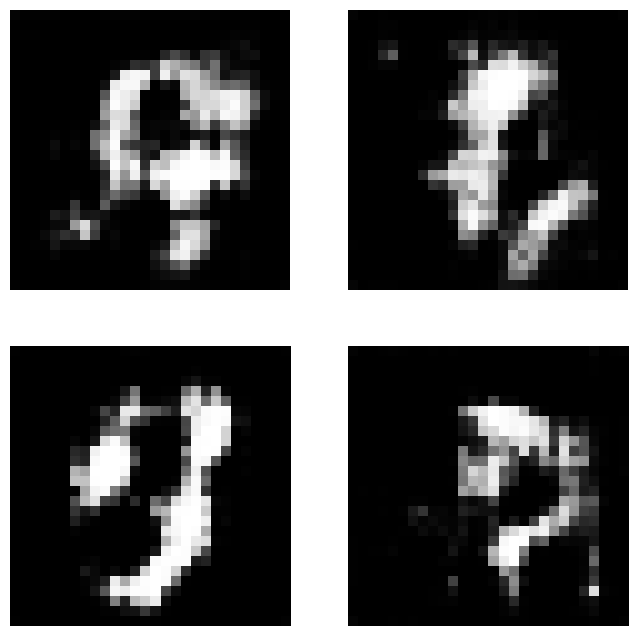

Epoch 1000
 disc loss: 0.513494074344635, disc acc: 0.46875
 gen loss: 3.7418665885925293


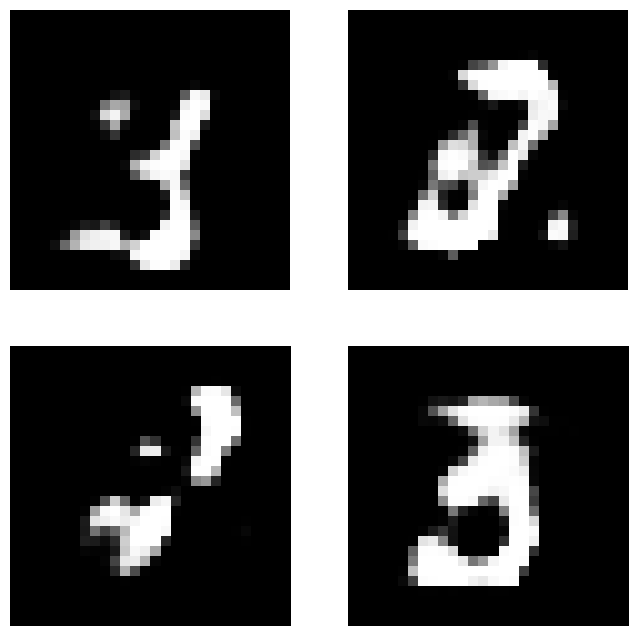

Epoch 1500
 disc loss: 0.48653873801231384, disc acc: 0.40625
 gen loss: 3.4225730895996094


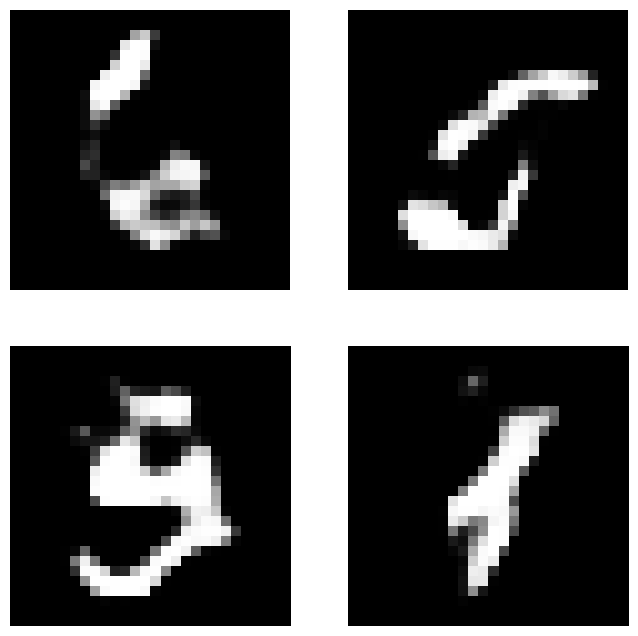

Epoch 2000
 disc loss: 0.4522421956062317, disc acc: 0.453125
 gen loss: 1.6824311017990112


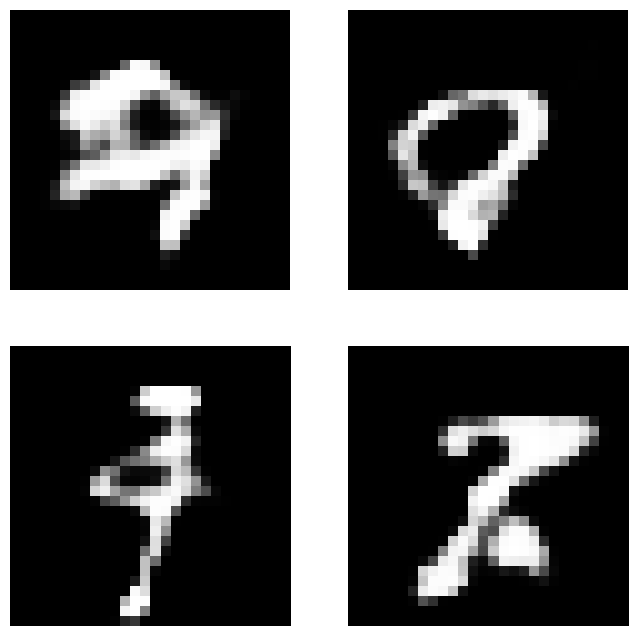

Epoch 2500
 disc loss: 0.4074977934360504, disc acc: 0.453125
 gen loss: 1.9365990161895752


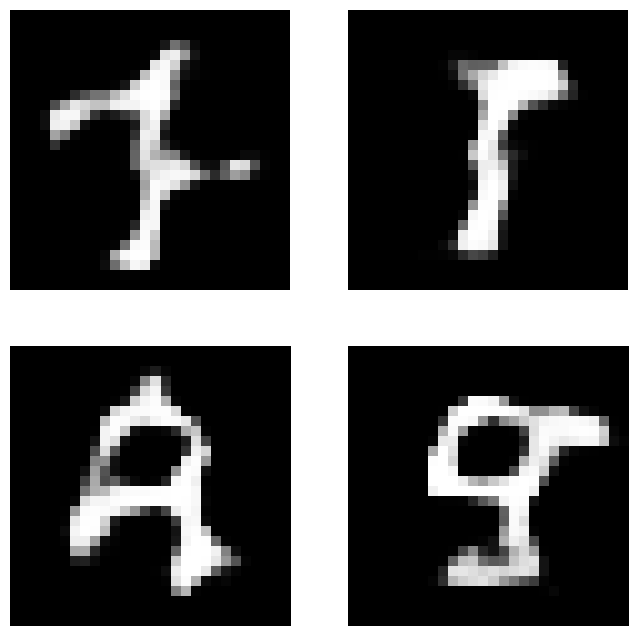

Epoch 3000
 disc loss: 0.49691274762153625, disc acc: 0.4453125
 gen loss: 2.3294901847839355


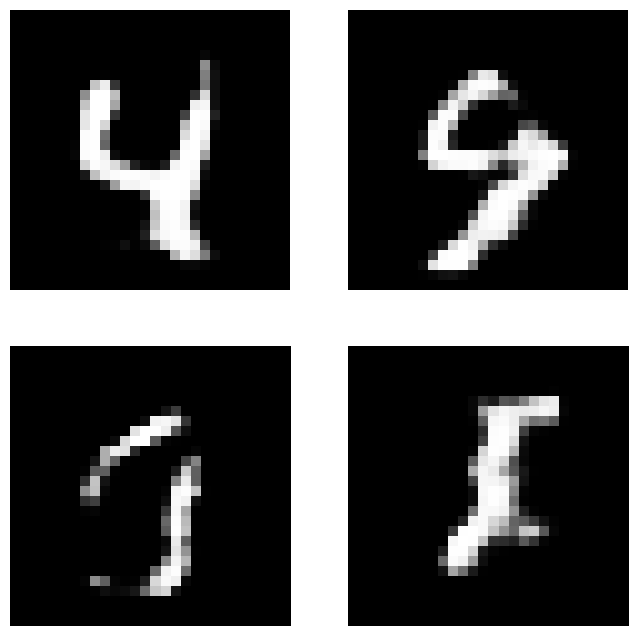

Epoch 3500
 disc loss: 0.42087092995643616, disc acc: 0.453125
 gen loss: 1.8245043754577637


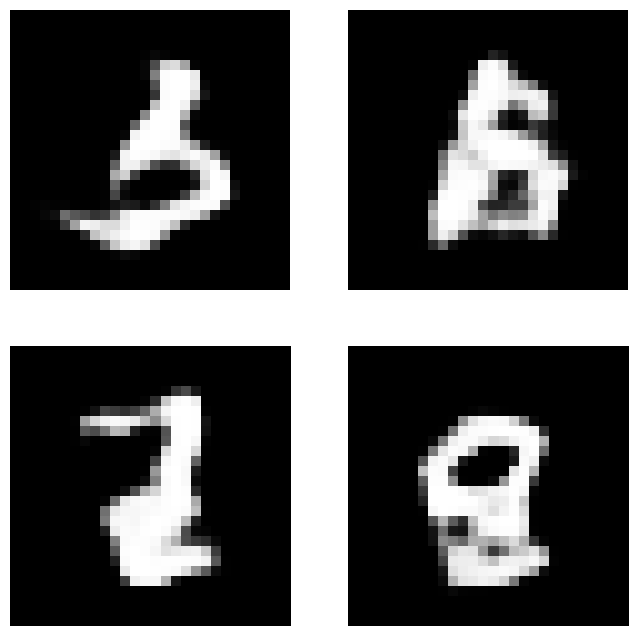

Epoch 4000
 disc loss: 0.4495594799518585, disc acc: 0.4765625
 gen loss: 1.8958650827407837


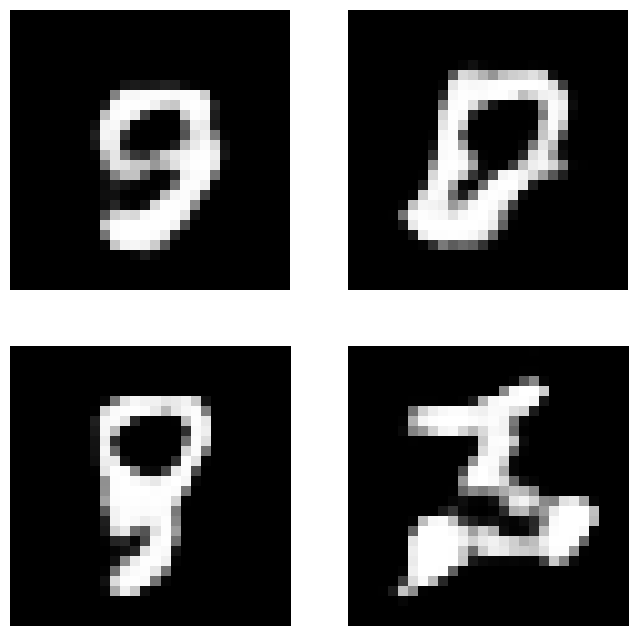

Epoch 4500
 disc loss: 0.4565819799900055, disc acc: 0.453125
 gen loss: 1.8672974109649658


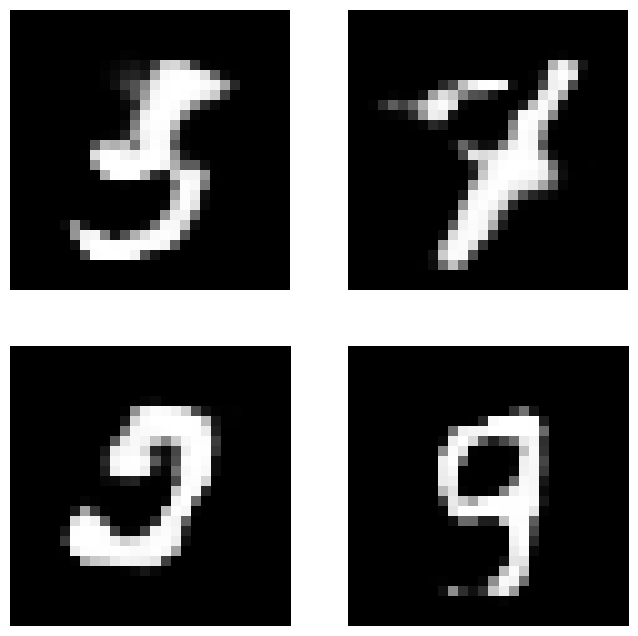

Epoch 4999
 disc loss: 0.44828224182128906, disc acc: 0.453125
 gen loss: 1.6227948665618896


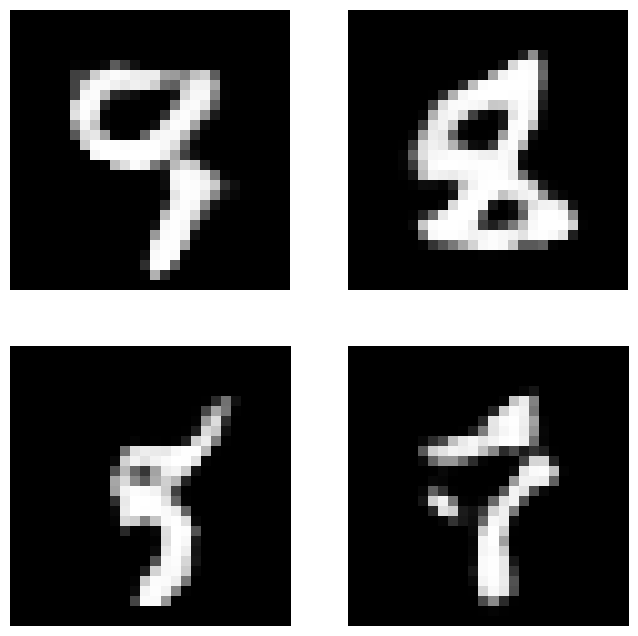

In [37]:
discriminator_model.trainable = False
gan_input = tf.keras.layers.Input(shape=noise_dim)
generated_image = generator_model(gan_input)
gan_output = discriminator_model(generated_image)
gan_model = tf.keras.models.Model(gan_input, gan_output, name="gan_model")
gan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

tf.keras.utils.disable_interactive_logging()

gan_model.summary()

# Training loop for the GAN
epochs = 5000
batch_size = 64

def plot_metrics(d_loss, g_loss, d_accuracy):
    plt.figure(figsize=(12, 6))

    # Plot Discriminator Loss
    plt.subplot(1, 2, 1)
    plt.plot(d_loss, label='Discriminator Loss', color='blue')
    plt.plot(g_loss, label='Generator Loss', color='orange')
    plt.title('Discriminator and Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Discriminator Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(d_accuracy, label='Discriminator Accuracy', color='blue')
    plt.title('Discriminator and Generator Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def see_generated_images(epoch, generator):
  noise = np.random.normal(0, 1, (4, noise_dim[0]))  # Generate 4 images for display
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5

  fig, axs = plt.subplots(2, 2, figsize=(8, 8))
  cnt = 0

  for i in range(2):
      for j in range(2):
          axs[i, j].imshow(generated_images[cnt], cmap = 'gray')
          axs[i, j].axis('off')
          cnt += 1
  plt.show()
  plt.close()

#store metric
d_loss_history = []
g_loss_history = []
d_accuracy_history = []

for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, noise_dim[0]))

    generated_images = generator_model.predict(noise)

    real_images, real_labels = next(iter(ds_train))

    X = np.concatenate([real_images, generated_images])

    y_dis = np.zeros(2 * batch_size)
    y_dis[:batch_size] = 0.9  # Label smoothing for real images

    d_loss = discriminator_model.train_on_batch(X, y_dis)

    noise = np.random.normal(0, 1, (batch_size, noise_dim[0]))

    y_gen = np.ones(batch_size)

    g_loss = gan_model.train_on_batch(noise, y_gen)

    d_loss_history.append(d_loss[0])
    g_loss_history.append(g_loss[0])
    d_accuracy_history.append(d_loss[1])

    if epoch % 500 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch}\n disc loss: {d_loss[0]}, disc acc: {d_loss[1]}\n gen loss: {g_loss[0]}")
        if epoch % 1000 == 0:
          #store model weights
          generator_model.save_weights('/content/gdrive/MyDrive/gans_mnist_training/generator_w_'+str(epoch))
          discriminator_model.save_weights('/content/gdrive/MyDrive/gans_mnist_training/discriminator_w_'+str(epoch))
        # show generated images
        see_generated_images(epoch, generator_model)

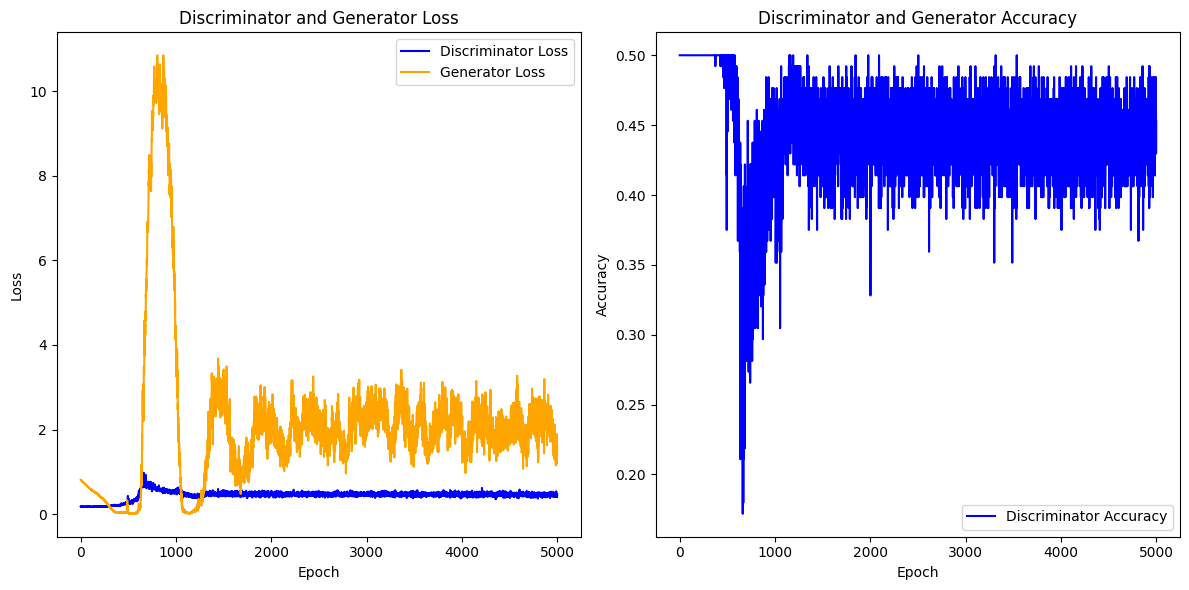

In [38]:
plot_metrics(d_loss_history, g_loss_history, d_accuracy_history)